## Day 25 Lecture 1 Assignment

In this assignment, we will evaluate the performance of the model we built yesterday on the Chicago traffic crash data. We will also perform hyperparameter tuning and evaluate a final model using additional metrics (e.g. AUC-ROC, precision, recall, etc.)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups_vectorized
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
%matplotlib inline

Since we will be building on the model we built in the last assignment, we will need to redo all of the data preparation steps up to the point of model building. These steps include creating the response, missing value imputation, and one-hot encoding our selected categorical variables. The quickest way to get going would be to open last week's assignment, make a copy, and build on it from there.

Statsmodels' implementation of logistic has certain advantages over scikit-learn's, such as clean, easy to read model summary output and statistical inference values (e.g. p-values). However, scikit-learn is preferable for model evaluation, so we will switch to the scikit-learn implementation for this exercise. 

Run logistic regression on the training set and use the resulting model to make predictions on the test set. Calculate the train and test error using logarithmic loss. How do they compare to each other?

In [ ]:
# answer goes here

def missingness_summary(df, print_log=False, sort='none'):
    summary = df.apply(lambda x: x.isna().sum() / x.shape[0])
    
    if print_log == True:
        if sort == 'none':
            print(summary)
        elif sort == 'ascending':
            print(summary.sort_values())
        elif sort == 'descending':
            print(summary.sort_values(ascending=False))
        else:
            print('Invalid value for sort parameter.')
        
    return summary

crash_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')

crash_data['DAMAGE'] = crash_data['DAMAGE'].apply(lambda x: 1 if (x == "OVER $1,500") else 0 )

summary = missingness_summary(crash_data)
summary = summary[summary < 0.05]
crash_data = crash_data[summary.index]

temp = crash_data._get_numeric_data()
crash= temp.iloc[:, :-1].fillna(temp.median())
crash['STREET_NO'] = temp['STREET_NO']
crash['WEATHER_CONDITION'] = crash_data['WEATHER_CONDITION']  
crash['FIRST_CRASH_TYPE'] = crash_data['FIRST_CRASH_TYPE']


dataset = crash[['DAMAGE', 'POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'INJURIES_TOTAL', 'FIRST_CRASH_TYPE']]
new_temp = pd.get_dummies(dataset[['WEATHER_CONDITION', 'FIRST_CRASH_TYPE']], drop_first = True)
dataset = pd.concat([dataset, new_temp], axis= 1)
dataset = dataset.drop(columns=['WEATHER_CONDITION_CLEAR', 'WEATHER_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CRASH_TYPE_REAR END'], axis=1)


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

crash_X = dataset.iloc[:, 1::]
crash_Y = dataset.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(crash_X, crash_Y, test_size=0.2)
X_train_const = sm.add_constant(X_train)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=500)
logit.fit(X_train, y_train)
train_score = logit.score(X_train, y_train)
test_score = logit.score(X_test, y_test)

In [ ]:
from sklearn.metrics import log_loss
test_pred_probs = logit.predict_proba(X_test)
train_pred_probs = logit.predict_proba(X_train)
test_log_loss = log_loss(y_test, test_pred_probs)
train_log_loss = log_loss(y_train, train_pred_probs)
print(f'Test log loss: {test_log_loss}')
print(f'Train log loss: {train_log_loss}')

Test log loss: 0.6616035957095602
Train log loss: 0.6610511999696537


Next, evaluate the performance of the same model using 10-fold CV. Use the training data and labels, and print out the mean log loss for each of the 10 CV folds, as well as the overall CV-estimated test error. How do the estimates from the individual folds compare to the result from our previous single holdout set? How much variability in the estimated test error do you see across the 10 folds?

Note: scikit-learn's *cross_val_score* function provides a simple, one-line method for doing this. However, be careful - the default score returned by this function may not be log loss!

In [ ]:
# answer goes here
clf = LogisticRegression(solver='lbfgs')
cv_scores = cross_val_score(clf, X_train, y_train, cv = 5)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy scores for the 5 folds:  [0.58489617 0.58405744 0.58435938 0.581551   0.58349689]
Mean cross validatiion score: 0.584


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print('Accuracy scores for the 5 folds: ', cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 5 folds:  [0.58489617 0.58405744 0.58435938 0.581551   0.58349689]
Mean cross validatiion score: 0.584


Scikit-learn's logistic regression function has a built-in regularization parameter, C (the larger the value of C, the smaller the degree of regularization). Use a loop with values of C, and find the optimum C value by taking the highest average cross validation score.

In [ ]:
# answer goes here
highest_acv = []
c = [0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0]

for _ in c:
  logit = LogisticRegression(max_iter=100, C=_)
  cv = cross_val_score(logit, X_train, y_train, cv=5)
  highest_acv.append(cv.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
for _ in range(len(highest_acv)):
  print(f'C value: {c[_]}, Average Cross Validation: {highest_acv[_]}')

C value: 0.5, Average Cross Validation: 0.5836788839214553
C value: 1.0, Average Cross Validation: 0.5836721744821426
C value: 5.0, Average Cross Validation: 0.5837090785650761
C value: 10.0, Average Cross Validation: 0.5835715273209026
C value: 25.0, Average Cross Validation: 0.5835849464246412
C value: 50.0, Average Cross Validation: 0.5838935994862483
C value: 100.0, Average Cross Validation: 0.5837090790715805


Re-train a logistic regression model using the best value of C identified by 10-fold CV on the training data and labels. Afterwards, do the following:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Note: the performance of our simple logistic regression model with just four features will not be very good, but this is not entirely unexpected. There are many other features that can be incorporated into the model to improve its performance; feel free to experiment!

In [ ]:
# answer goes here
logit = LogisticRegression(max_iter=1000, C=50)
logit.fit(X_train, y_train)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
train_predicted_y = logit.predict(X_train)
print(classification_report(y_train, train_predicted_y))

              precision    recall  f1-score   support

           0       0.62      0.12      0.20    130075
           1       0.58      0.94      0.72    167993

    accuracy                           0.58    298068
   macro avg       0.60      0.53      0.46    298068
weighted avg       0.60      0.58      0.49    298068



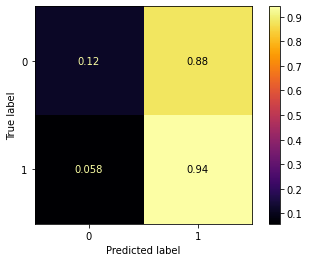

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(y_train, train_predicted_y, labels=[0,1])
plot_confusion_matrix(logit, X_test, y_test, cmap='inferno', normalize='true')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
train_pred_probs = logit.predict_proba(X_train)
pred_probs = pd.Series(train_pred_probs[:, 1])
x, y, _ = roc_curve(y_train, pred_probs)
roc_auc = auc(x, y)

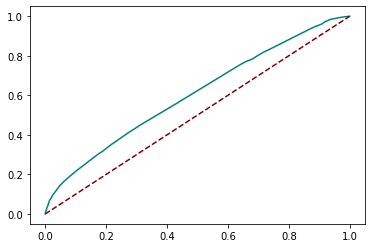

In [ ]:
plt.plot(x, y, color='teal')
plt.plot([0, 1], [0, 1], color='maroon', linestyle='--')
plt.show()